In [10]:
!pip install --upgrade pandas xgboost pyarrow google-cloud-bigquery scikit-learn matplotlib db-dtypes google-cloud-bigquery-storage

  Using cached pandas-1.5.3-cp38-cp38-macosx_11_0_arm64.whl (10.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.7 MB/s eta 0:00:00a 0:00:010m
  Using cached pyarrow-11.0.0-cp38-cp38-macosx_11_0_arm64.whl (22.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.5/215.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 11.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 11.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.2
    Uninstalling xgboost-1.7.2:
      Successfully uninstalled xgboost-1.7.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.0
    Uninstalling scikit-learn-1.2.0:
      Successfully uninstalled scikit-learn-1.2.0
  Attempting uninsta

In [6]:
PROJECT_ID = 'vertex-ai-test-365213'
LOCATION = "us-central1"
DATASET = "eliasecchi_dev"
TABLE = "transactions__feature_creation_sample"
FEATURESTORE_ID  = "test_feature_store"
SERVING_FEATURE_IDS = {"customer": ["avg_tx_amount_7d", "count_tx_28d"], "terminal": ["max_tx_amount_28d", "max_tx_amount_90d"]}

In [2]:

import datetime
import io
import json
import logging
import pandas as pd

from google.cloud import bigquery
from typing import Dict, List
from google.cloud import bigquery
from xgboost import XGBRegressor
from google.cloud import aiplatform as vertex_ai
from google.cloud.aiplatform import Featurestore, EntityType, Feature


def get_schema_from_query_job(
    client: bigquery.client.Client, query_job: bigquery.job.QueryJob
) -> dict:
    f = io.StringIO("")
    result = query_job.result()
    client.schema_to_json(result.schema, f)
    return json.loads(f.getvalue())


def bq_schema_to_dtypes(bq_schema: List[Dict[str, str]]) -> Dict[str, str]:
    mapping_dict = {
        "STRING": "str",
        "INTEGER": "int",
        "FLOAT": "float",
        "NUMERIC": "float",
        "BOOLEAN": "bool",
    }
    return {column["name"]: mapping_dict.get(column["type"], "object") for column in bq_schema}


def get_casted_df_from_query(client, sql):
    job = client.query(sql)
    bq_schema = get_schema_from_query_job(client=client, query_job=job)
    dtypes = bq_schema_to_dtypes(bq_schema=bq_schema)
    df = job.to_dataframe(dtypes=dtypes)
    return df

client = bigquery.Client(project=PROJECT_ID, location=LOCATION)
vertex_ai.init(
    project=PROJECT_ID,
    location=LOCATION
)
feature_store = Featurestore(FEATURESTORE_ID)



In [4]:
pass_through_fields=["tx_fraud", "tx_amount", "avg_tx_amount_by_customer_id_1h_1s","avg_tx_amount_by_customer_id_28d_1s",
                         "avg_tx_amount_by_customer_id_90d_1s","min_tx_amount_by_customer_id_1h_1s","min_tx_amount_by_customer_id_5d_1s"]


In [8]:
# Let's select a sample of our training dataset for the training split
sql = f"""
    SELECT tx_id,tx_ts as timestamp,customer_id as customer,terminal_id as terminal,created_timestamp, {','.join(pass_through_fields)}
    FROM `{PROJECT_ID}.{DATASET}.{TABLE}` 
    WHERE tx_ts >= "2022-06-01" AND tx_ts < "2022-07-01"
    AND ABS(MOD(FARM_FINGERPRINT(tx_id), 100)) = 1 
"""
df_train_read_instance = get_casted_df_from_query(client=client, sql=sql)
df_train = feature_store.batch_serve_to_df(
    serving_feature_ids=SERVING_FEATURE_IDS,
    read_instances_df=df_train_read_instance,
    pass_through_fields=pass_through_fields,
)


Serving Featurestore feature values: projects/370018035372/locations/us-central1/featurestores/test_feature_store
Serve Featurestore feature values backing LRO: projects/370018035372/locations/us-central1/featurestores/test_feature_store/operations/2165186678560391168
Featurestore feature values served. Resource name: projects/370018035372/locations/us-central1/featurestores/test_feature_store


In [9]:
# Let's select a sample of our validation dataset for the training split
sql = f"""
    SELECT tx_id,tx_ts as timestamp,customer_id as customer,terminal_id as terminal,created_timestamp, {','.join(pass_through_fields)}
    FROM `{PROJECT_ID}.{DATASET}.{TABLE}` 
    WHERE tx_ts >= "2022-07-01" AND tx_ts < "2022-07-10"
    AND ABS(MOD(FARM_FINGERPRINT(tx_id), 100)) = 1 
"""
df_val_read_instance = get_casted_df_from_query(client=client, sql=sql)
df_val = feature_store.batch_serve_to_df(
    serving_feature_ids=SERVING_FEATURE_IDS,
    read_instances_df=df_train_read_instance,
    pass_through_fields=pass_through_fields,
)

Serving Featurestore feature values: projects/370018035372/locations/us-central1/featurestores/test_feature_store
Serve Featurestore feature values backing LRO: projects/370018035372/locations/us-central1/featurestores/test_feature_store/operations/800595991467130880
Featurestore feature values served. Resource name: projects/370018035372/locations/us-central1/featurestores/test_feature_store


In [14]:
EXCLUDE_COLUMNS= ['tx_id','timestamp','entity_type_customer', 'entity_type_terminal', 'created_timestamp']
CATEGORICAL_COLUMNS = []
LABEL = 'tx_fraud'

training_columns = [column for column in list(df_train.columns) if column not in EXCLUDE_COLUMNS + [LABEL]]

# Setting the type of some columns to category
df_train[CATEGORICAL_COLUMNS] = df_train[CATEGORICAL_COLUMNS].astype('category')
df_val[CATEGORICAL_COLUMNS] = df_train[CATEGORICAL_COLUMNS].astype('category')

In [15]:
x = df_train[training_columns]
y = df_train[[LABEL]]
x_val = df_val[training_columns]
y_val =  df_val[[LABEL]]

In [16]:
model = XGBRegressor(enable_categorical=True, tree_method="hist")
model.fit(x,y, eval_set=[(x_val,y_val)])

[0]	validation_0-rmse:0.35223
[1]	validation_0-rmse:0.24953
[2]	validation_0-rmse:0.17878
[3]	validation_0-rmse:0.13056
[4]	validation_0-rmse:0.09845
[5]	validation_0-rmse:0.07792
[6]	validation_0-rmse:0.06530
[7]	validation_0-rmse:0.05806
[8]	validation_0-rmse:0.05399
[9]	validation_0-rmse:0.05168
[10]	validation_0-rmse:0.04943
[11]	validation_0-rmse:0.04878
[12]	validation_0-rmse:0.04745
[13]	validation_0-rmse:0.04702
[14]	validation_0-rmse:0.04662
[15]	validation_0-rmse:0.04570
[16]	validation_0-rmse:0.04456
[17]	validation_0-rmse:0.04429
[18]	validation_0-rmse:0.04396
[19]	validation_0-rmse:0.04317
[20]	validation_0-rmse:0.04265
[21]	validation_0-rmse:0.04210
[22]	validation_0-rmse:0.04042
[23]	validation_0-rmse:0.03838
[24]	validation_0-rmse:0.03807
[25]	validation_0-rmse:0.03741
[26]	validation_0-rmse:0.03716
[27]	validation_0-rmse:0.03632
[28]	validation_0-rmse:0.03596
[29]	validation_0-rmse:0.03546
[30]	validation_0-rmse:0.03483
[31]	validation_0-rmse:0.03472
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: >

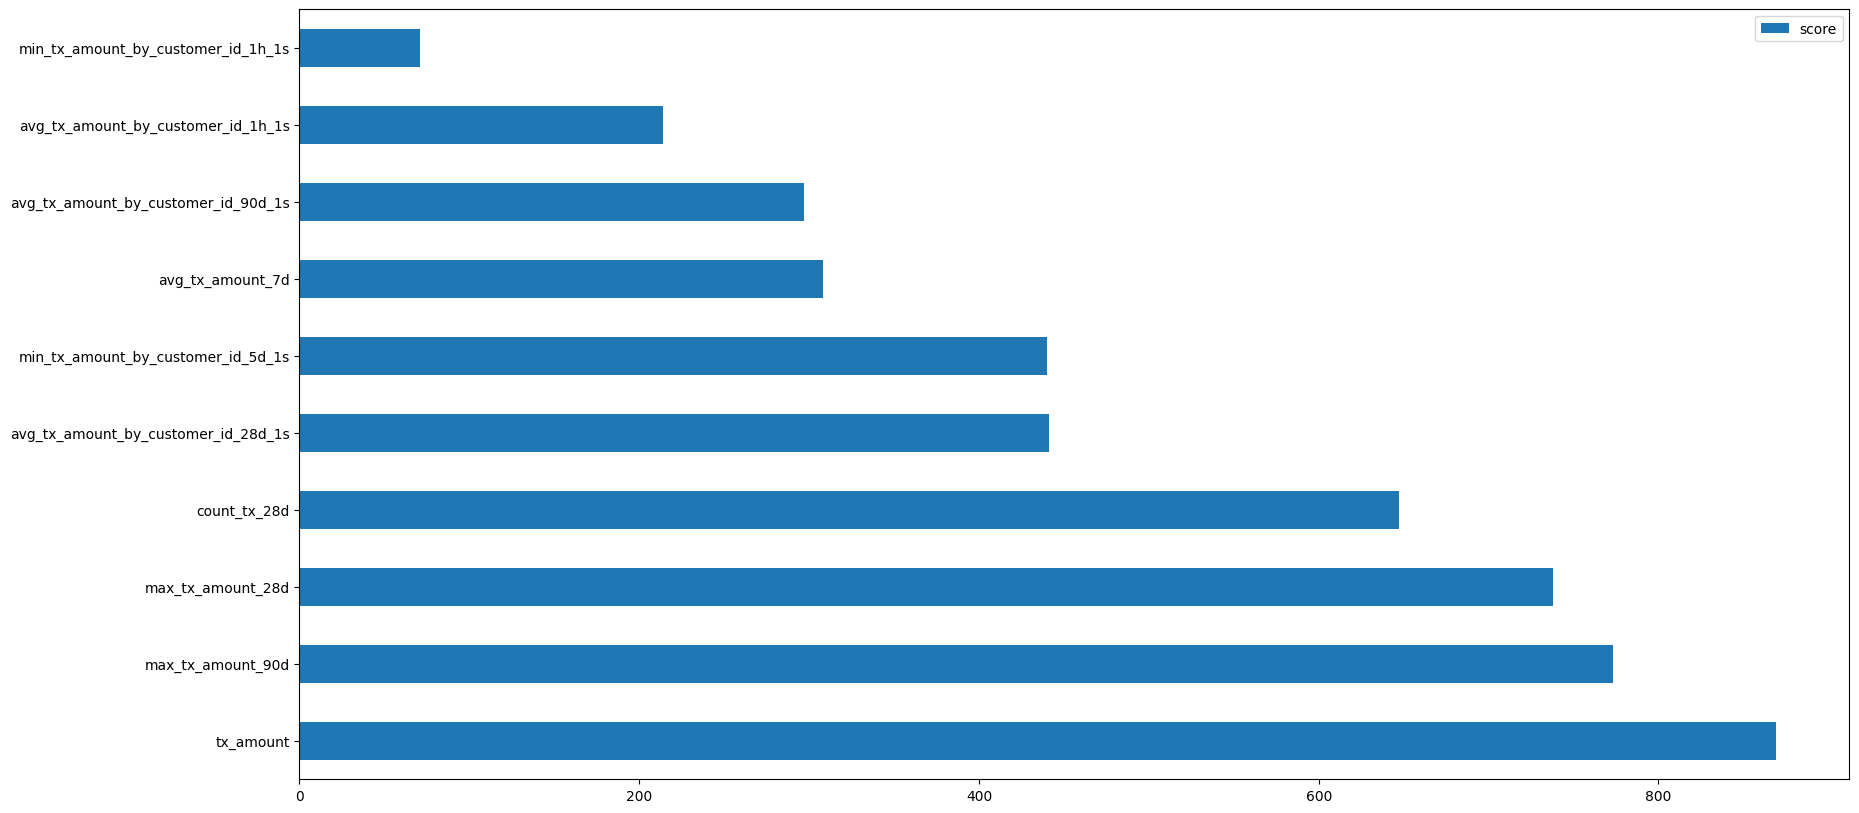

In [17]:
# Print feature importances
feature_importance = model.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [18]:
x.columns

Index(['tx_amount', 'avg_tx_amount_by_customer_id_1h_1s',
       'avg_tx_amount_by_customer_id_28d_1s',
       'avg_tx_amount_by_customer_id_90d_1s',
       'min_tx_amount_by_customer_id_1h_1s',
       'min_tx_amount_by_customer_id_5d_1s', 'avg_tx_amount_7d',
       'count_tx_28d', 'max_tx_amount_28d', 'max_tx_amount_90d'],
      dtype='object')